In [39]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
%matplotlib inline
from keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [26]:
# Image size
im_width = 400
im_height = 400
path_train_x = 'training/images/'
path_train_y = 'training/groundtruth/'

In [27]:
def load_images(path, x=True):
    ids = next(os.walk(path))[2]
    N = len(ids)
    images = np.empty((len(ids), im_height, im_width, 3 if x else 1)).astype('float32')
    for i, id_ in enumerate(ids):
        if (x):
            img = load_img(path + id_, target_size=(400,400))
        else:
            img = load_img(path + id_, target_size=(400,400), color_mode="grayscale")
        images[i] = img_to_array(img)/255.
    return images

In [28]:
images = load_images(path_train_x)
masks = load_images(path_train_y, x=False)

In [48]:
# we create two instances with the same arguments
data_gen_args = dict(rotation_range=90.,
                     horizontal_flip = True,
                    vertical_flip = True
                    )

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = random.randint(1,101)
image_datagen.fit(images, augment=True, seed=seed)
mask_datagen.fit(masks, augment=True, seed=seed)

msk = []
img = []


In [49]:
#1st implementation of image expansion
id = 0
n_images_max = 1
for batch in image_datagen.flow(images, batch_size=1, seed=1337):
    img.append(batch[id])
    id = id+1
    if id >= n_images_max:
        break

id = 0
for batch in mask_datagen.flow(masks, batch_size=1, seed=1337): 
    msk.append(batch[id])
    id = id+1
    if id >= n_images_max:
        break

In [50]:
#implementation using zip
image_generator = image_datagen.flow(images, batch_size=1, seed=1337)
mask_generator = mask_datagen.flow(masks, batch_size=1, seed=1337)

train_generator = zip(image_generator, mask_generator)

id = 0
for images, masks in train_generator:
    for image, mask in zip(images, masks):
        img.append(image)
        msk.append(mask)
        
    id += 1
    if id >= n_images_max:
        break

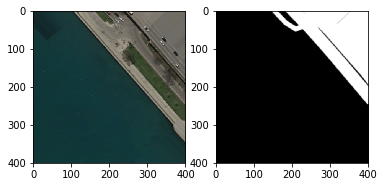

In [51]:
 # display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img[0]);
ax[1].imshow(msk[0][:,:,0], cmap="gray");